# Clasificacion y explicabilidad (MNIST)

## Explicabilidad

AAE para entrenar un espacio latente para explicar el resultado de la clasificacion.

### Preparacion de los datos

In [3]:
from lib.utilities import unpickle, tryDataset, mkfolders, os

(60000, 28, 28, 1)


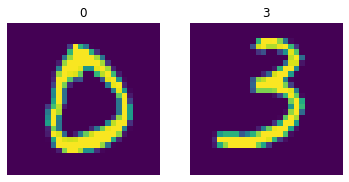

(10000, 28, 28, 1)


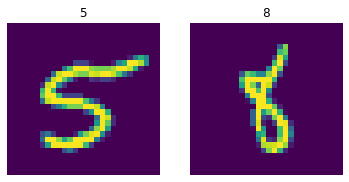

In [4]:
X_train = unpickle("Input\MNIST-train")
X_test = unpickle("Input\MNIST-test")
tryDataset(X_train)
tryDataset(X_test)

Tamaño de las imagenes:

In [3]:
img_shape = X_train["data"][0].shape

### Entrenamiento

#### Persistencia

In [13]:
_raiz = "Resultados/MNIST_ClasifExpl"
_nombre = "MNIST"

Creamos las carpetas para almacenar el output

In [5]:
mkfolders(_raiz, True)

Carpeta Resultados/MNIST_ClasifExpl ya existe


#### Entrenamiento en grid

In [5]:
from lib.discriminadores import build_class_discriminator
from lib.genEJ import true_multivariate_sampler_tf, fake_class_sampler
from keras import losses

In [6]:
from lib.compilado import assemble_AAE_twoPhased
from lib.entrenamiento import fit_AAE_twoPhased
from lib.convolucional import build_conv_decoder, build_conv_encoder
from lib.muestreo import show_prevResults, plot_history, sample_imgs, exploraLatente

In [7]:
epochs = 12

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def plotlatent2D(encoder, dataset, ruta=_raiz, nombre=_nombre):
    ruta+="/Output/Latente"
    mkfolders(ruta)
    points = encoder.predict(dataset["data"])

    x = np.array(list(x for (x,_) in points))
    y = np.array(list(y for (_,y) in points))
    colors = dataset["labels"]

    plt.scatter(x, y, c=colors, cmap='hsv')

    #mixture = compute_mixture(dataset, encoder, points)
    #colors, x, y = [], [], []
    #for key in mixture.keys():
    #    colors.append(key)
    #    x.append(mixture[key]["mu"][0])
    #    y.append(mixture[key]["mu"][1])
    #plt.scatter(x, y, c=colors, cmap='hsv', marker="*", edgecolors="black")

    plt.colorbar()
    fig = plt.gcf()
    plt.show()
    fig.savefig(ruta+"\\"+nombre+"_space.jpg")
    plt.close()

In [9]:
def tryModel(
    model_name="MODEL", 
    assemble_AAE=assemble_AAE_twoPhased,
    loss_weights=[0.999, 0.001], 
    fit_AAE = fit_AAE_twoPhased,
    enc= (build_conv_encoder, "conv_enc", {}), 
    dec = (build_conv_decoder,"conv_dec", {}),
    ae_loss = (losses.mean_squared_error, "ae_MSE_loss"),
    disc = (build_class_discriminator ,"class_disc", {"clases":10}, {"truth":true_multivariate_sampler_tf, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler}),
    disc_loss = (losses.binary_crossentropy, "disc_binXentropy_loss"),
    dim_latente = 2,
    save=False
    ):
    # Carpeta donde almacenar los resultados
    ruta = _raiz+"\\"+model_name
    # Si existen los modelos solo mostrar resultados guardados sin entrenar
    if os.path.isfile(ruta+"/Modelos\\decoder.h5"):
        print(ruta+" ya ha sido entrenada")
        show_prevResults(ruta, epochs=epochs)
        return
    # Crear carpeta
    mkfolders(ruta, True)
    # Parametros para el entrenamiento
    fit_settings = disc[3]
    # Creacion de los modelos
    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], enc_kwargs=enc[2], dec_model = dec[0], dec_kwargs=dec[2], disc_model = disc[0], disc_kwargs=disc[2], ae_loss=ae_loss[0], disc_loss=disc_loss[0], loss_weights=loss_weights)
    # Entrenamiento
    history = fit_AAE(aae=aae, dim_latente=dim_latente, dataset=X_train, epochs = epochs, ruta = ruta, **fit_settings)
    # Obtenemos informacion del numero de clases para mostrar resultados
    clases=0
    if "clases" in disc[2].keys():
        clases=disc[2]["clases"]
    
    #Resultados
    print("Historia del entrenamiento:")
    plot_history(history, ruta=ruta, title=ruta)
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
    sample_imgs(X_train, aae[3], epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    sample_imgs(X_test, aae[3], epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
    print("Representacion del espacio latente 2D:")
    plotlatent2D(aae[0], X_test, ruta=ruta, nombre="TESTSET")
    # Guardado de modelos
    if save:
        mkfolders(ruta+"/Modelos")
        aae[0].save(ruta+"/Modelos\\encoder.h5")
        aae[1].save(ruta+"/Modelos\\decoder.h5")
        #aae[3].save(ruta+"/Modelos\\autoencoder.h5")


##### Red convolucional

Normal Multivariada (con tf) 

Carpeta Resultados/MNIST_ClasifExpl\ConvAAE ya existe
Entrenando: Resultados/MNIST_ClasifExpl\ConvAAE
E0 <██████████> 100% DISC: [loss: 0.030555, acc: 99.00%] AAE: [mse: 0.071014, b_ce: 0.059556] 120.21s		
E1 <██████████> 100% DISC: [loss: 0.090642, acc: 98.00%] AAE: [mse: 0.070607, b_ce: 0.057004] 116.98s		
E2 <██████████> 100% DISC: [loss: 0.068618, acc: 97.50%] AAE: [mse: 0.068283, b_ce: 0.052359] 119.79s		
E3 <██████████> 100% DISC: [loss: 0.226894, acc: 92.00%] AAE: [mse: 0.062179, b_ce: 0.049148] 122.88s		
E4 <██████████> 100% DISC: [loss: 0.136665, acc: 96.00%] AAE: [mse: 0.057959, b_ce: 0.046926] 119.08s		
E5 <██████████> 100% DISC: [loss: 0.174474, acc: 92.00%] AAE: [mse: 0.057436, b_ce: 0.048329] 116.15s		
E6 <██████████> 100% DISC: [loss: 0.133764, acc: 94.00%] AAE: [mse: 0.059310, b_ce: 0.048487] 118.74s		
E7 <██████████> 100% DISC: [loss: 0.199210, acc: 91.50%] AAE: [mse: 0.057706, b_ce: 0.047777] 127.54s		
E8 <██████████> 100% DISC: [loss: 0.171496, acc: 93.50%] AAE: [mse

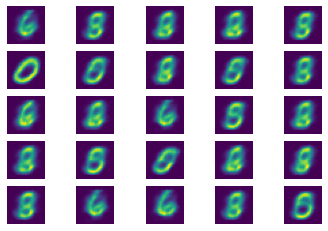

Historia del entrenamiento:


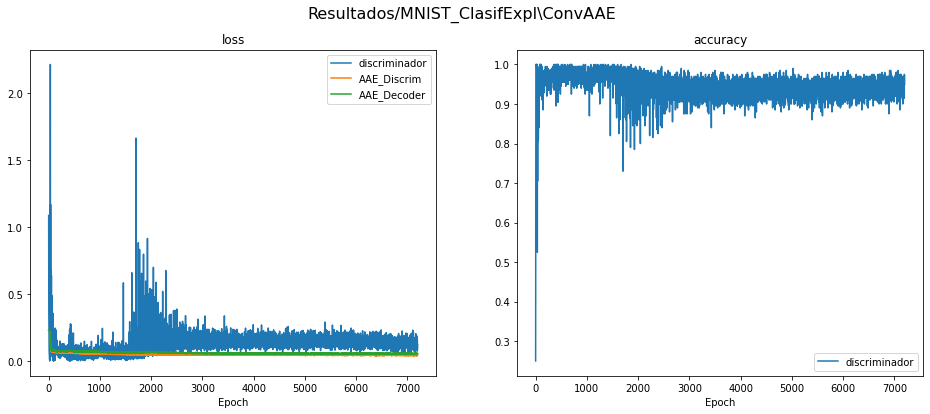

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


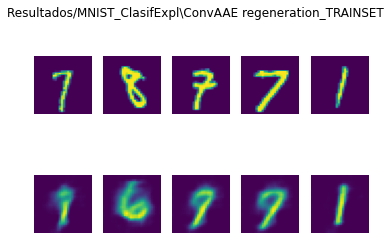

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


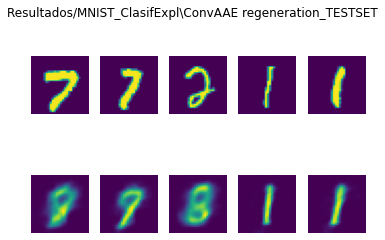

Representacion del espacio latente 2D:


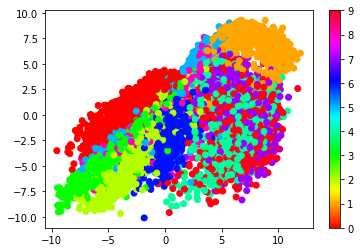

In [12]:
model_name = "ConvAAE"
tryModel(model_name=model_name, save=True)

Normal Multivariada (sin tf)

Entrenando: Resultados/MNIST_ClasifExpl\ConvAAE2
E0 <██████████> 100% DISC: [loss: 0.099719, acc: 97.50%] AAE: [mse: 0.066028, b_ce: 0.055409] 79.81s		
E1 <██████████> 100% DISC: [loss: 0.184134, acc: 89.00%] AAE: [mse: 0.063015, b_ce: 0.054387] 72.58s		
E2 <██████████> 100% DISC: [loss: 0.142174, acc: 91.50%] AAE: [mse: 0.059412, b_ce: 0.049677] 71.41s		
E3 <██████████> 100% DISC: [loss: 0.239644, acc: 87.50%] AAE: [mse: 0.056648, b_ce: 0.049252] 70.20s		
E4 <██████████> 100% DISC: [loss: 0.164904, acc: 95.00%] AAE: [mse: 0.053149, b_ce: 0.045192] 69.86s		
E5 <██████████> 100% DISC: [loss: 0.252485, acc: 89.50%] AAE: [mse: 0.054897, b_ce: 0.046650] 71.18s		
E6 <██████████> 100% DISC: [loss: 0.259077, acc: 88.50%] AAE: [mse: 0.056699, b_ce: 0.047820] 71.65s		
E7 <██████████> 100% DISC: [loss: 0.327286, acc: 85.00%] AAE: [mse: 0.052898, b_ce: 0.046400] 71.77s		
E8 <██████████> 100% DISC: [loss: 0.233894, acc: 89.00%] AAE: [mse: 0.051824, b_ce: 0.045181] 71.53s		
E9 <██████████> 100% DIS

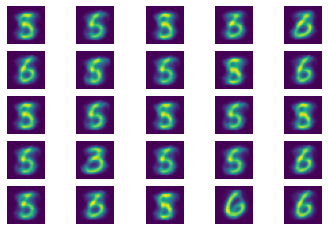

Historia del entrenamiento:


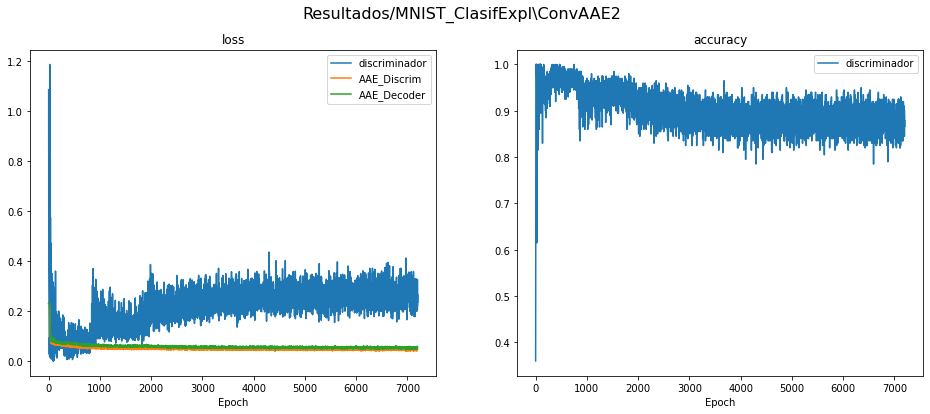

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


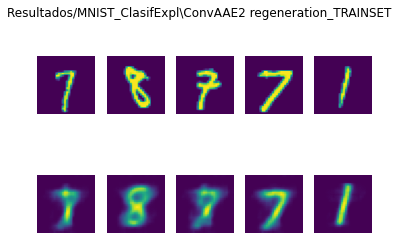

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


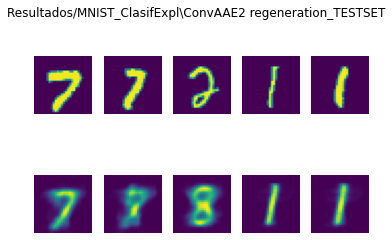

Representacion del espacio latente 2D:


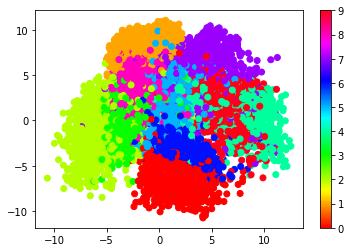

In [11]:
from lib.genEJ import true_multivariate_sampler
model_name = "ConvAAE2"
disc = (build_class_discriminator ,"class_disc", {"clases":10}, {"truth":true_multivariate_sampler, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
tryModel(model_name=model_name, disc=disc, save=True)

Normal Multivariada (sin tf) pesos iguales

Entrenando: Resultados/MNIST_ClasifExpl\ConvAAE2_equalweigths
E0 <██████████> 100% DISC: [loss: 0.355228, acc: 83.50%] AAE: [mse: 3.774255, b_ce: 0.057244] 73.58s		
E1 <██████████> 100% DISC: [loss: 0.422024, acc: 80.00%] AAE: [mse: 4.238663, b_ce: 0.059563] 73.17s		
E2 <██████████> 100% DISC: [loss: 0.496993, acc: 72.00%] AAE: [mse: 3.185705, b_ce: 0.057178] 72.15s		
E3 <██████████> 100% DISC: [loss: 0.507291, acc: 71.50%] AAE: [mse: 2.636080, b_ce: 0.055958] 71.97s		
E4 <██████████> 100% DISC: [loss: 0.494496, acc: 75.00%] AAE: [mse: 2.926645, b_ce: 0.055391] 69.72s		
E5 <██████████> 100% DISC: [loss: 0.475503, acc: 77.00%] AAE: [mse: 2.968607, b_ce: 0.053540] 69.31s		
E6 <██████████> 100% DISC: [loss: 0.472715, acc: 79.50%] AAE: [mse: 3.077232, b_ce: 0.057684] 71.86s		
E7 <██████████> 100% DISC: [loss: 0.500308, acc: 69.00%] AAE: [mse: 2.637925, b_ce: 0.054400] 72.45s		
E8 <██████████> 100% DISC: [loss: 0.598574, acc: 69.50%] AAE: [mse: 2.417722, b_ce: 0.053492] 70.97s		
E9 <███████

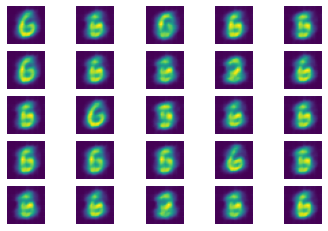

Historia del entrenamiento:


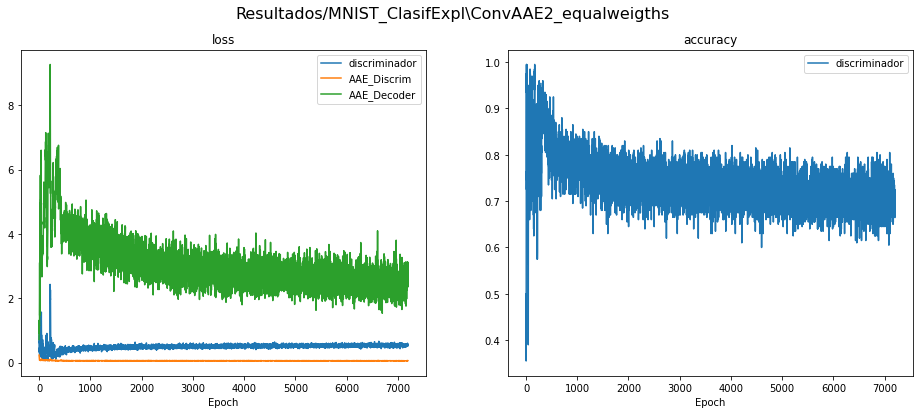

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


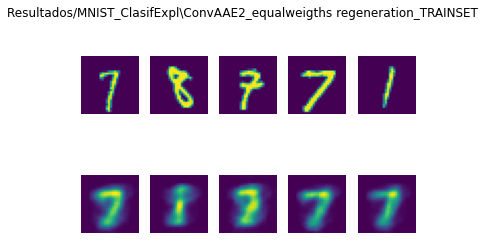

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


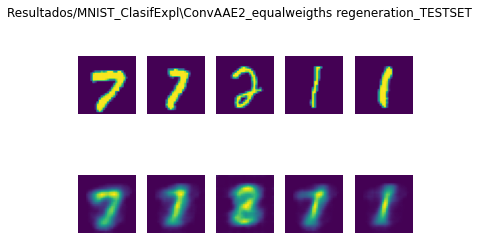

Representacion del espacio latente 2D:


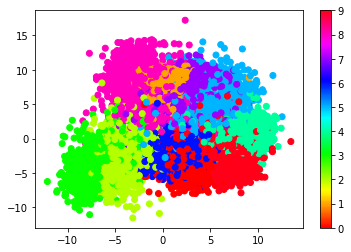

In [12]:
from lib.genEJ import true_multivariate_sampler
model_name = "ConvAAE2_equalweights"
disc = (build_class_discriminator ,"class_disc", {"clases":10}, {"truth":true_multivariate_sampler, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
tryModel(model_name=model_name, disc=disc, loss_weights=[1,1],save=True)

In [13]:
import numpy as np
def generateRandomVectors(dim_latente, batch_size, nclases, **kwargs):
    vectors = []
    labels = np.zeros((batch_size, nclases))
    
    for label in labels:
        l = np.random.randint(0, nclases)
        label[l] = 1
        mean = [10*np.cos((l*2*np.pi)/10), 10*np.sin((l*2*np.pi)/10)]
        v1 = [np.cos((l*2*np.pi)/10), np.sin((l*2*np.pi)/10)]
        v2 = [-np.sin((l*2*np.pi)/10), np.cos((l*2*np.pi)/10)]
        a1 = 8
        a2 = .4
        M =np.vstack((v1,v2)).T
        S = np.array([[a1, 0], [0, a2]])
        cov = np.dot(np.dot(M, S), np.linalg.inv(M))
        #cov = cov*cov.T
        vec = np.random.multivariate_normal(mean=mean, cov=cov,
                                            size=1)
        vectors.append(vec)
    return (np.array(vectors).reshape(-1, 2), labels)

Multivariada vectores

Carpeta Resultados/MNIST_ClasifExpl\ConvAAE_VEC ya existe
Entrenando: Resultados/MNIST_ClasifExpl\ConvAAE_VEC
E0 <██████████> 100% DISC: [loss: 0.167521, acc: 90.50%] AAE: [mse: 0.056652, b_ce: 0.050521] 79.19s		
E1 <██████████> 100% DISC: [loss: 0.113776, acc: 95.00%] AAE: [mse: 0.056914, b_ce: 0.050272] 76.39s		
E2 <██████████> 100% DISC: [loss: 0.113909, acc: 96.00%] AAE: [mse: 0.052666, b_ce: 0.046581] 75.68s		
E3 <██████████> 100% DISC: [loss: 0.153244, acc: 92.50%] AAE: [mse: 0.050553, b_ce: 0.045188] 75.94s		
E4 <██████████> 100% DISC: [loss: 0.152845, acc: 95.00%] AAE: [mse: 0.048550, b_ce: 0.042127] 75.60s		
E5 <██████████> 100% DISC: [loss: 0.276392, acc: 86.50%] AAE: [mse: 0.050165, b_ce: 0.044647] 76.20s		
E6 <██████████> 100% DISC: [loss: 0.162626, acc: 92.00%] AAE: [mse: 0.050754, b_ce: 0.044803] 75.46s		
E7 <██████████> 100% DISC: [loss: 0.159772, acc: 93.50%] AAE: [mse: 0.048651, b_ce: 0.043894] 75.42s		
E8 <██████████> 100% DISC: [loss: 0.125714, acc: 94.00%] AAE: [mse

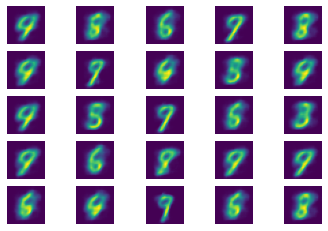

Historia del entrenamiento:


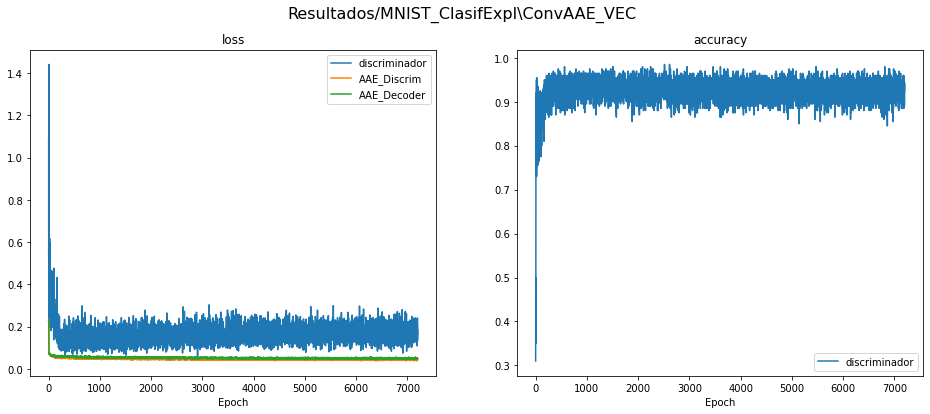

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


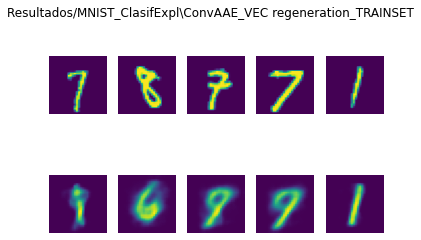

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


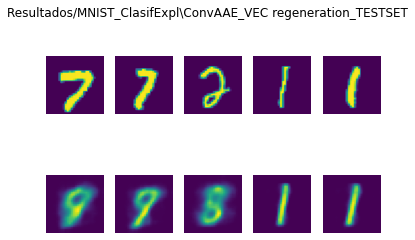

Representacion del espacio latente 2D:


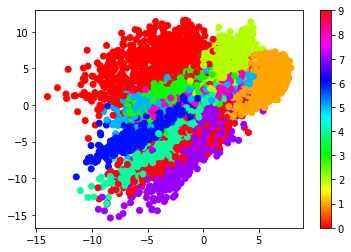

In [20]:
disc=(build_class_discriminator ,"class_disc",{"clases":10}, {"truth":generateRandomVectors, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
model_name = "ConvAAE_VEC"
tryModel(disc=disc, model_name=model_name, save=True)

Multivariada vectores pesos iguales

Carpeta Resultados/MNIST_ClasifExpl\ConvAAE_VEC_equalweigths ya existe
Entrenando: Resultados/MNIST_ClasifExpl\ConvAAE_VEC_equalweigths
E0 <██████████> 100% DISC: [loss: 0.105965, acc: 98.00%] AAE: [mse: 6.119158, b_ce: 0.063423] 78.65s		
E1 <██████████> 100% DISC: [loss: 0.784548, acc: 90.50%] AAE: [mse: 17.675270, b_ce: 0.065971] 77.53s		
E2 <██████████> 100% DISC: [loss: 0.051359, acc: 98.50%] AAE: [mse: 7.643583, b_ce: 0.060440] 78.45s		
E3 <██████████> 100% DISC: [loss: 0.115515, acc: 96.50%] AAE: [mse: 15.475717, b_ce: 0.062069] 77.25s		
E4 <██████████> 100% DISC: [loss: 0.342466, acc: 90.50%] AAE: [mse: 6.047001, b_ce: 0.057920] 76.65s		
E5 <██████████> 100% DISC: [loss: 0.108499, acc: 95.50%] AAE: [mse: 5.541876, b_ce: 0.054648] 77.12s		
E6 <██████████> 100% DISC: [loss: 0.304914, acc: 88.50%] AAE: [mse: 4.609940, b_ce: 0.059727] 78.60s		
E7 <██████████> 100% DISC: [loss: 0.334900, acc: 85.00%] AAE: [mse: 3.674603, b_ce: 0.057826] 78.27s		
E8 <██████████> 100% DISC: [loss: 0.36

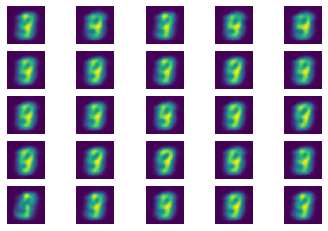

Historia del entrenamiento:


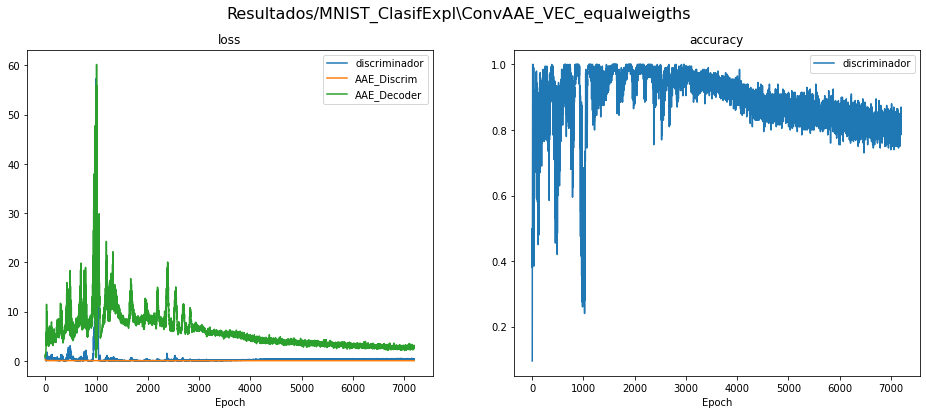

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


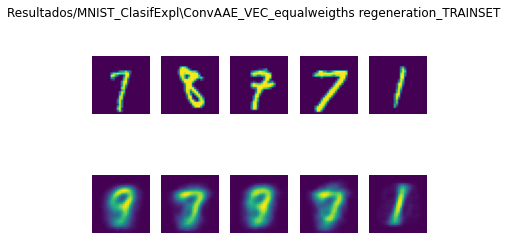

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


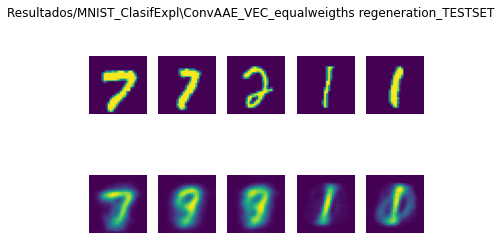

Representacion del espacio latente 2D:


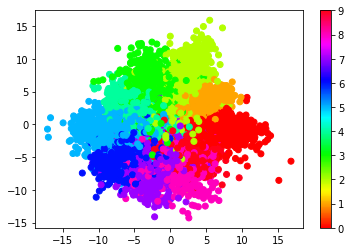

In [19]:
disc=(build_class_discriminator ,"class_disc",{"clases":10}, {"truth":generateRandomVectors, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
model_name = "ConvAAE_VEC_equalweights"
tryModel(disc=disc, loss_weights=[1,1], model_name=model_name, save=True)

##### Red densa (Espacio latente mas limpio)

Multivariada vectores pesos iguales

Carpeta Resultados/MNIST_ClasifExpl\DenseAAE_VEC ya existe
Entrenando: Resultados/MNIST_ClasifExpl\DenseAAE_VEC
E0 <██████████> 100% DISC: [loss: 0.658892, acc: 56.00%] AAE: [mse: 0.951690, b_ce: 0.055712] 76.12s		
E1 <██████████> 100% DISC: [loss: 0.680757, acc: 55.00%] AAE: [mse: 0.881207, b_ce: 0.054752] 73.89s		
E2 <██████████> 100% DISC: [loss: 0.677111, acc: 55.00%] AAE: [mse: 0.855453, b_ce: 0.052444] 73.36s		
E3 <██████████> 100% DISC: [loss: 0.678569, acc: 56.00%] AAE: [mse: 0.810730, b_ce: 0.051462] 73.98s		
E4 <██████████> 100% DISC: [loss: 0.678335, acc: 58.50%] AAE: [mse: 0.827498, b_ce: 0.049568] 74.43s		
E5 <██████████> 100% DISC: [loss: 0.700468, acc: 45.00%] AAE: [mse: 0.767046, b_ce: 0.051320] 73.28s		
E6 <██████████> 100% DISC: [loss: 0.697240, acc: 41.00%] AAE: [mse: 0.794019, b_ce: 0.052017] 75.39s		
E7 <██████████> 100% DISC: [loss: 0.687156, acc: 52.50%] AAE: [mse: 0.786363, b_ce: 0.049623] 75.61s		
E8 <██████████> 100% DISC: [loss: 0.688504, acc: 61.50%] AAE: [m

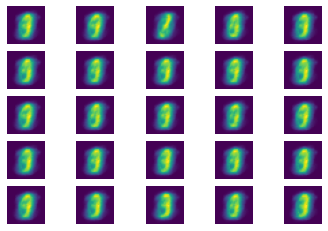

Historia del entrenamiento:


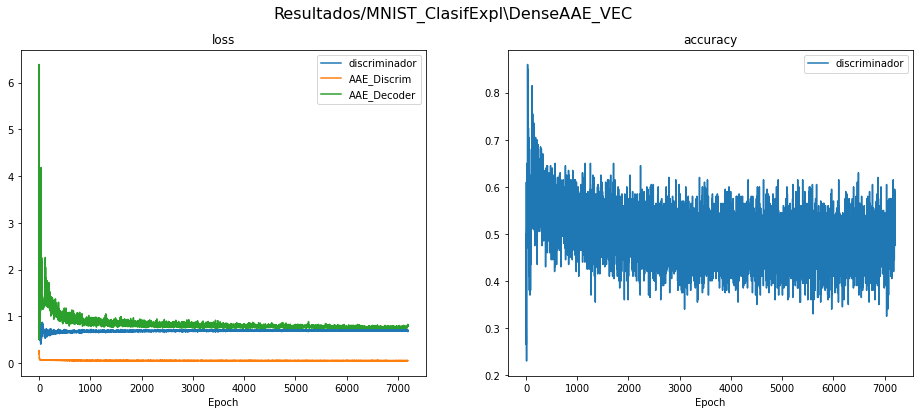

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


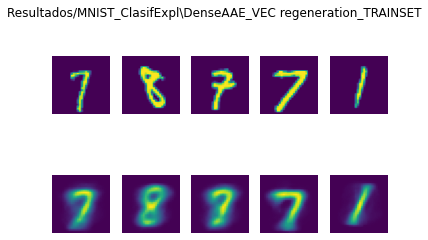

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


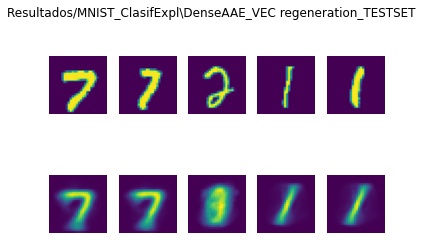

Representacion del espacio latente 2D:


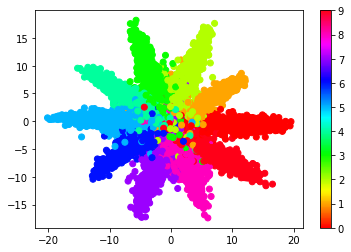

In [18]:
from lib.densa import build_dense_decoder, build_dense_encoder
enc= (build_dense_encoder, "dense_enc", {})
dec = (build_dense_decoder,"dense_dec", {})
disc=(build_class_discriminator ,"class_disc",{"clases":10}, {"truth":generateRandomVectors, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
model_name = "DenseAAE_VEC_equalweights"
tryModel(enc=enc, dec=dec, disc=disc, loss_weights=[1,1], model_name=model_name, save=True)

Normal Multivariada pesos iguales

Carpeta Resultados/MNIST_ClasifExpl\DenseAAE_equalweights ya existe
Entrenando: Resultados/MNIST_ClasifExpl\DenseAAE_equalweights
E0 <██████████> 100% DISC: [loss: 0.569654, acc: 70.50%] AAE: [mse: 1.618124, b_ce: 0.057834] 71.37s		
E1 <██████████> 100% DISC: [loss: 0.617647, acc: 63.00%] AAE: [mse: 1.369186, b_ce: 0.057912] 74.60s		
E2 <██████████> 100% DISC: [loss: 0.629792, acc: 62.00%] AAE: [mse: 1.124907, b_ce: 0.053698] 70.70s		
E3 <██████████> 100% DISC: [loss: 0.661887, acc: 57.00%] AAE: [mse: 0.978081, b_ce: 0.052742] 70.67s		
E4 <██████████> 100% DISC: [loss: 0.672660, acc: 55.00%] AAE: [mse: 0.977057, b_ce: 0.052315] 69.44s		
E5 <██████████> 100% DISC: [loss: 0.670790, acc: 47.50%] AAE: [mse: 1.018004, b_ce: 0.053290] 69.79s		
E6 <██████████> 100% DISC: [loss: 0.676769, acc: 53.00%] AAE: [mse: 0.963266, b_ce: 0.053488] 69.04s		
E7 <██████████> 100% DISC: [loss: 0.670015, acc: 57.50%] AAE: [mse: 0.990927, b_ce: 0.051551] 71.35s		
E8 <██████████> 100% DISC: [loss: 0.666843, ac

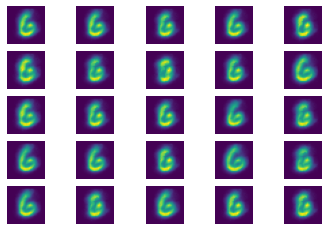

Historia del entrenamiento:


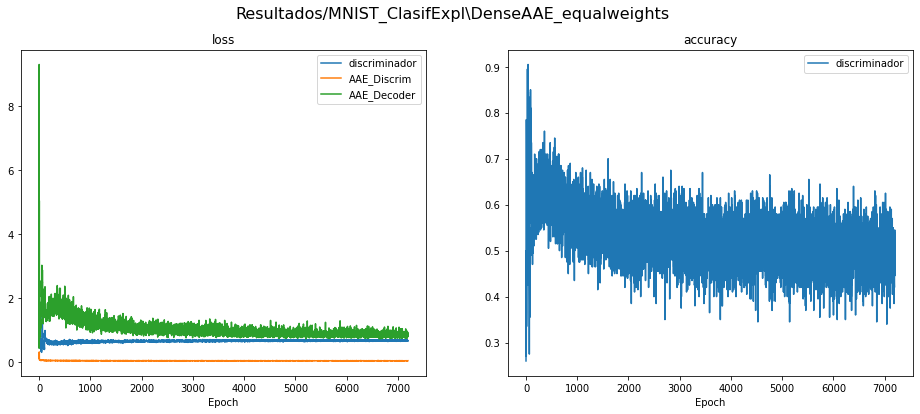

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


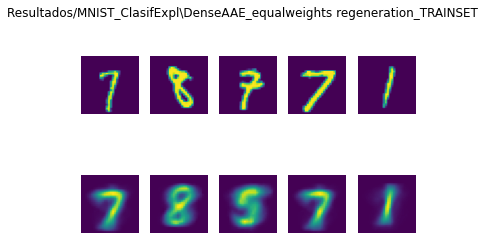

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


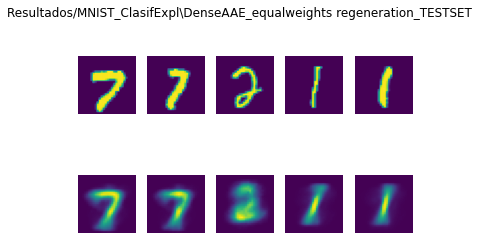

Representacion del espacio latente 2D:


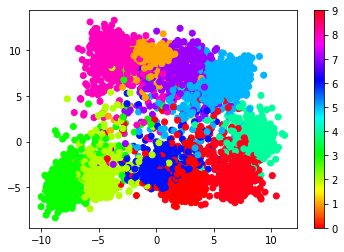

In [22]:
from lib.densa import build_dense_decoder, build_dense_encoder
enc= (build_dense_encoder, "dense_enc", {})
dec = (build_dense_decoder,"dense_dec", {})
disc=(build_class_discriminator ,"class_disc",{"clases":10}, {"truth":true_multivariate_sampler, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
model_name = "DenseAAE_equalweights"
tryModel(enc=enc, dec=dec, disc=disc, loss_weights=[1,1], model_name=model_name, save=True)

## Clasificacion k vecinos

In [10]:
import keras

In [6]:
encoder = keras.models.load_model(_raiz+"/ConvAAE/Modelos/encoder.h5")

### Base de datos de coordenadas latentes

Cargado de coordenadas latentes desde el encoder

In [15]:
import numpy as np
def loadLatentSpace(dataset, encoder):
    latent=encoder.predict(dataset["data"])
    labels = dataset["labels"]
    save = []
    
    for i in range(len(latent)):
        s = (latent[i], labels[i], i) # (coordenada, etiqueta, indice)
        print(i, end="\r")
        save.append(s)
    return save

In [8]:
latente=loadLatentSpace(X_train, encoder)   # (coordenada, etiqueta, indice)

Calculo de distancia a la coordenada

In [12]:
import tensorflow as tf
def getDistances(latentBBDD, predCoord):
    coords=[c for (c,_,_) in latentBBDD]
    labels = [l for (_,l,_) in latentBBDD]
    distances = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tf.math.subtract(coords, predCoord)), axis=1)).numpy()
    db = []
    for i, dist in enumerate(distances):
        d = (dist, labels[i], i)
        db.append(d)
    return db

In [17]:
import numpy as np
def getDistancesCPU(latentBBDD, predCoord):
    coords=[c for (c,_,_) in latentBBDD]
    labels = [l for (_,l,_) in latentBBDD]
    distances = np.sqrt(np.sum(np.square(np.subtract(coords, predCoord)), axis=1))
    db = []
    for i, dist in enumerate(distances):
        d = (dist, labels[i], i)
        db.append(d)
    return db

In [10]:
img = np.expand_dims(X_test["data"][0], axis=0)
coord = encoder.predict(img)[0]

In [11]:
distances = getDistances(latente, coord)

In [12]:
print(distances[0])

(5.7061553, 5, 0)


Orden

In [13]:
distances.sort(key=lambda tup: tup[0])

In [14]:
print(distances[0])

(0.0058333604, 9, 45879)


Prediccion en base de los k vecinos

In [14]:
def kNeightboursLatent(toPredict, latentBBDD, k=1):
    neightbours = getDistances(latentBBDD, toPredict)
    neightbours.sort(key=lambda tup: tup[0])
    neightbours=neightbours[:k]
    votes = [label for (_, label, _) in neightbours]
    return max(set(votes), key=votes.count)   

In [15]:
def kNeightboursLatentCPU(toPredict, latentBBDD, k=1):
    neightbours = getDistancesCPU(latentBBDD, toPredict)
    neightbours.sort(key=lambda tup: tup[0])
    neightbours=neightbours[:k]
    votes = [label for (_, label, _) in neightbours]
    return max(set(votes), key=votes.count)   

In [16]:
X_testLatent = encoder.predict(X_test["data"])

In [17]:
n=2
print("Label: %d Prediction: %d" % (X_test["labels"][n], kNeightboursLatent(X_testLatent[n], latente, 15)))

Label: 1 Prediction: 1


In [18]:
aciertos, fallos = 0,0
for i in range(len(X_testLatent)):
    if X_test["labels"][i] == kNeightboursLatent(X_testLatent[i], latente, 15):
        aciertos+=1
    else:
        fallos+=1
    print("Aciertos: %d | Fallos: %d" %(aciertos, fallos), end="\r")
# 19m 37.7s

In [21]:
aciertos, fallos = 0,0
for i in range(len(X_testLatent)):
    if X_test["labels"][i] == kNeightboursLatentCPU(X_testLatent[i], latente, 15):
        aciertos+=1
    else:
        fallos+=1
    print("Aciertos: %d | Fallos: %d" %(aciertos, fallos), end="\r")
# 11m 49.1s

## Pruebas de clasificacion

In [21]:
from IPython. display import Image, display
def tryClassification(modelName, BBDD_dataset, validation_dataset, k=15):
    print("Probando modelo "+modelName+": ")
    # Carga del espacio latente
    encoder = keras.models.load_model(_raiz+"/"+modelName+"/Modelos/encoder.h5")
    latente=loadLatentSpace(BBDD_dataset, encoder)

    # Visualizacion del espacio latente
    print("Espacio latente:")
    px = Image(filename=_raiz+"/"+modelName+"/Output/Latente/TESTSET_space.jpg")
    display(px)

    # Coordenadas a clasificar
    toPredict = encoder.predict(validation_dataset["data"])

    # Calculo de la precision de la clasificacion
    aciertos = 0
    for i in range(len(toPredict)):
        if X_test["labels"][i] == kNeightboursLatentCPU(toPredict[i], latente, k):
            aciertos+=1
        print("Aciertos: %d | Precision: %.2f%%" %(aciertos, (aciertos/(i+1))*100), end="\r")
    print()

Probando modelo ConvAAE: 
Espacio latente:


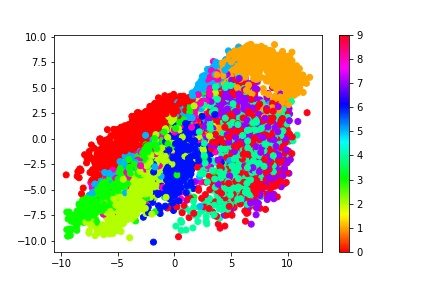

Aciertos: 5833 | Precision: 58.33%
Probando modelo ConvAAE2: 
Espacio latente:


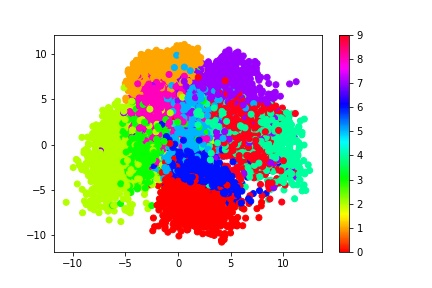

Aciertos: 6963 | Precision: 69.63%
Probando modelo ConvAAE2_equalweights: 
Espacio latente:


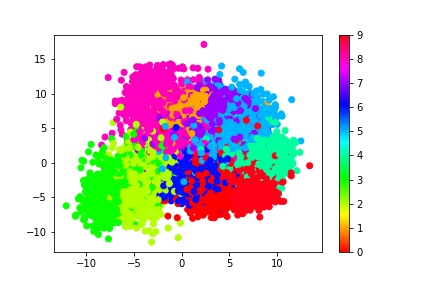

Aciertos: 7561 | Precision: 75.61%


In [27]:
models= ["ConvAAE", "ConvAAE2", "ConvAAE2_equalweights"]
for m in models:
    tryClassification(modelName=m, BBDD_dataset=X_train, validation_dataset=X_test, k=15)

Probando modelo ConvAAE_VEC: 
Espacio latente:


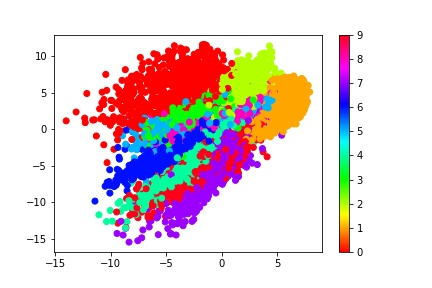

Aciertos: 6539 | Precision: 65.39%
Probando modelo ConvAAE_VEC_equalweights: 
Espacio latente:


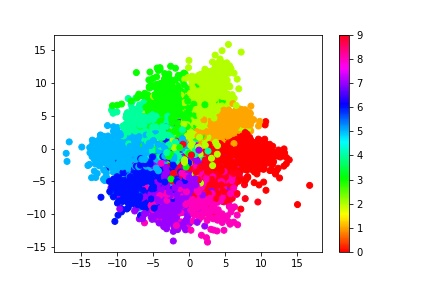

Aciertos: 6660 | Precision: 66.60%


In [24]:
models= ["ConvAAE_VEC", "ConvAAE_VEC_equalweights"]
for m in models:
    tryClassification(modelName=m, BBDD_dataset=X_train, validation_dataset=X_test, k=15)

Probando modelo DenseAAE_equalweights: 
Espacio latente:


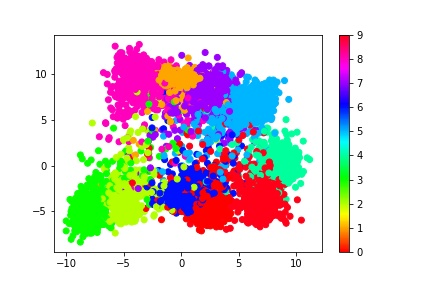

Aciertos: 9097 | Precision: 90.97%
Probando modelo DenseAAE_VEC_equalweights: 
Espacio latente:


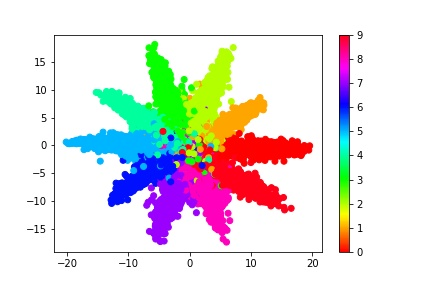

Aciertos: 9493 | Precision: 94.93%


In [26]:
models= ["DenseAAE_equalweights", "DenseAAE_VEC_equalweights"]
for m in models:
    tryClassification(modelName=m, BBDD_dataset=X_train, validation_dataset=X_test, k=15)

## Pruebas de explicabilidad

Explicabilidad por distancia en el espacio latente

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def explicaEspacio(latente, coord):
    points = [point for (point, _, _) in latente]

    x = np.array(list(x for (x,_) in points))
    y = np.array(list(y for (_,y) in points))
    colors =[label for (_, label, _) in latente]

    plt.scatter(x, y, c=colors, cmap='hsv')
    plt.colorbar()

    (x,y)=coord
    plt.scatter(x, y, c="black", marker="*", edgecolors="black")
    plt.show()

    plt.close()

Explicabilidad por semejanza a imagenes cercanas

In [7]:
def kNeightboursLatentCPU(toPredict, latentBBDD, k=1):
    neightbours = getDistancesCPU(latentBBDD, toPredict)
    neightbours.sort(key=lambda tup: tup[0])
    neightbours=neightbours[:k]
    votes = [label for (_, label, _) in neightbours]
    indices = [index for (_, _, index) in neightbours]
    return max(set(votes), key=votes.count), indices

In [31]:
def plotImgs(indices, BBDD_dataset):
    l = len(indices)
    f, arrx = plt.subplots(3,5)
    for i in range(l):
        arrx[int(i/5)][i%5].imshow(BBDD_dataset["data"][indices[i]])
        arrx[int(i/5)][i%5].axis("off")
    f.set_figwidth(6)
    plt.show()
    plt.close()

Clasificacion y explicacion

In [11]:
import matplotlib.pyplot as plt
import keras
def tryClassifixplain(modelName, BBDD_dataset, samples, k=15):
    print("Probando modelo "+modelName+": ")
    # Carga del espacio latente
    encoder = keras.models.load_model(_raiz+"/"+modelName+"/Modelos/encoder.h5")
    latente=loadLatentSpace(BBDD_dataset, encoder)

    # Coordenadas a clasificar
    toPredict = encoder.predict(samples["data"])

    for i in range(len(toPredict)):
        prediccion, indices = kNeightboursLatentCPU(toPredict[i], latente, k)
        print("IMAGEN:")
        plt.imshow(samples["data"][i])
        plt.axis("off")
        plt.show()
        plt.close()
        print("Etiqueta: ", samples["labels"][i]," Prediccion: ", prediccion)
        explicaEspacio(latente, toPredict[i])
        plotImgs(indices, BBDD_dataset)
    

### Pruebas

DenseAAE_VEC_equalweights

Probando modelo DenseAAE_VEC_equalweights: 
IMAGEN:


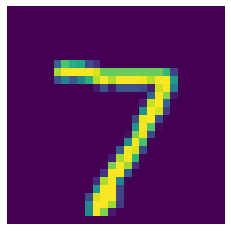

Etiqueta:  7  Prediccion:  7


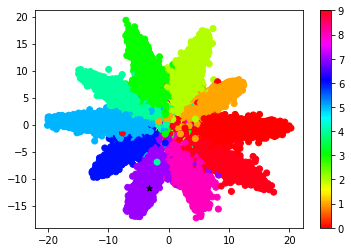

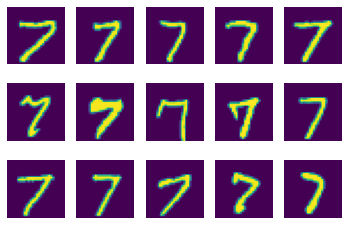

IMAGEN:


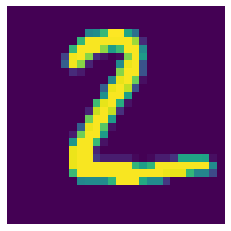

Etiqueta:  2  Prediccion:  2


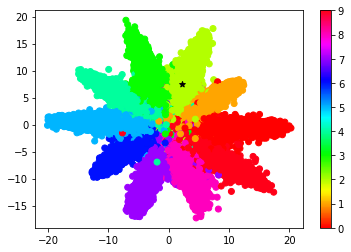

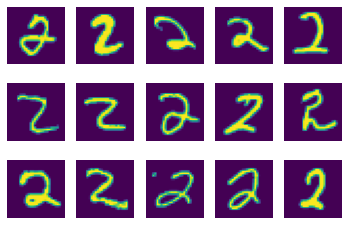

IMAGEN:


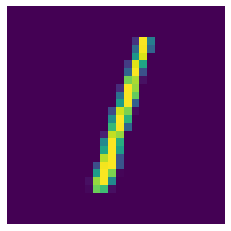

Etiqueta:  1  Prediccion:  1


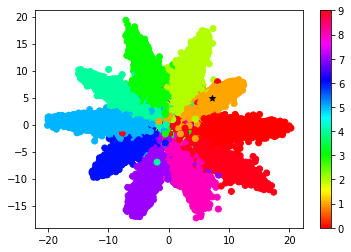

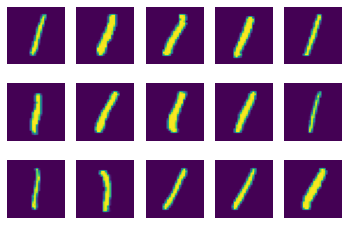

IMAGEN:


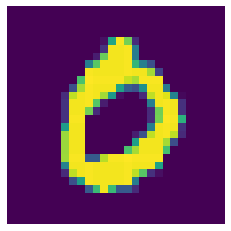

Etiqueta:  0  Prediccion:  0


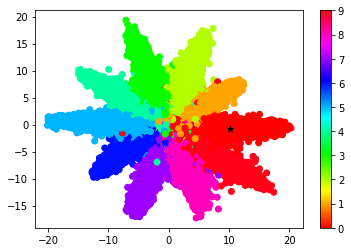

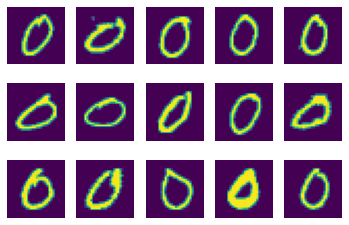

IMAGEN:


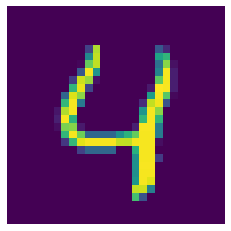

Etiqueta:  4  Prediccion:  4


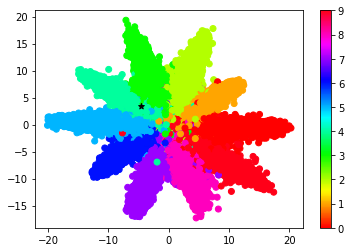

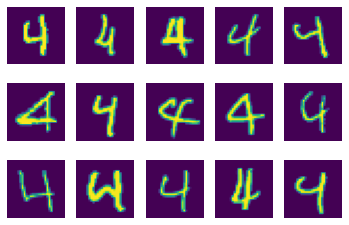

In [32]:
samples = {"data":X_test["data"][:5], "labels":X_test["labels"][:5]}
tryClassifixplain("DenseAAE_VEC_equalweights", BBDD_dataset=X_train, samples=samples, k=15)

ConvAAE2

Probando modelo ConvAAE2: 
IMAGEN:


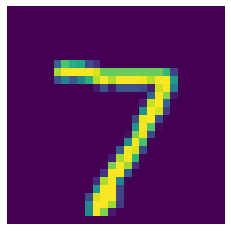

Etiqueta:  7  Prediccion:  7


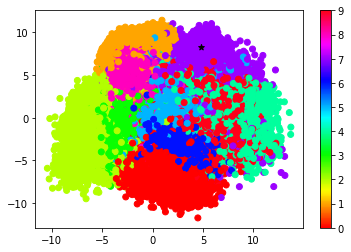

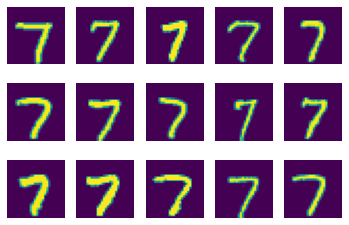

IMAGEN:


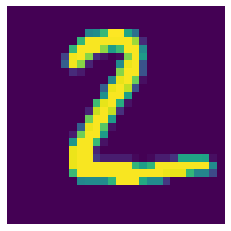

Etiqueta:  2  Prediccion:  2


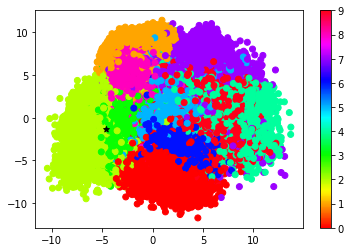

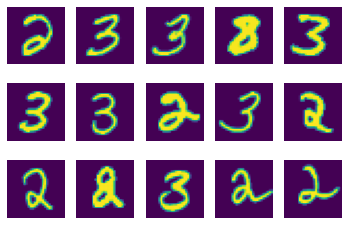

IMAGEN:


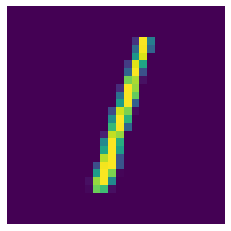

Etiqueta:  1  Prediccion:  1


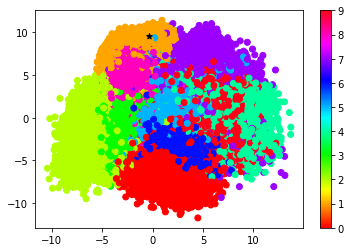

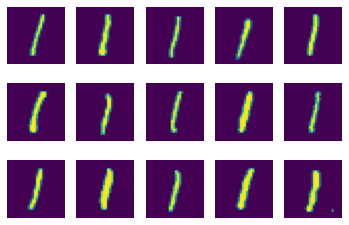

IMAGEN:


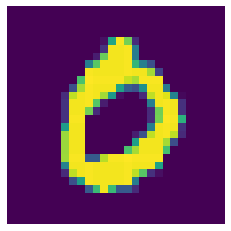

Etiqueta:  0  Prediccion:  0


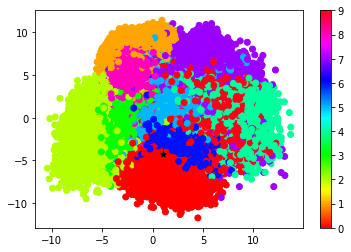

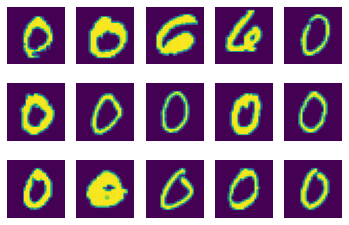

IMAGEN:


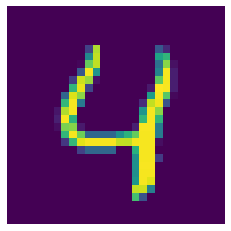

Etiqueta:  4  Prediccion:  4


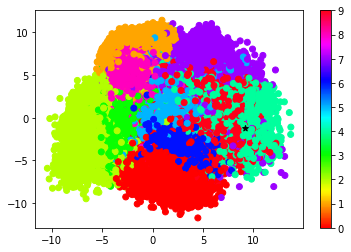

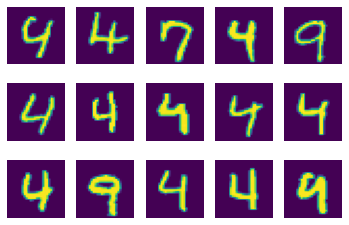

In [33]:
samples = {"data":X_test["data"][:5], "labels":X_test["labels"][:5]}
tryClassifixplain("ConvAAE2", BBDD_dataset=X_train, samples=samples, k=15)

ConvAAE2_equalweights

Probando modelo ConvAAE2_equalweights: 
IMAGEN:


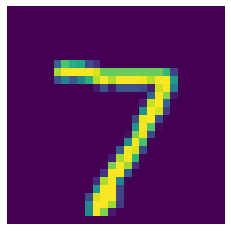

Etiqueta:  7  Prediccion:  1


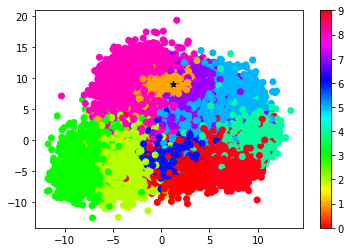

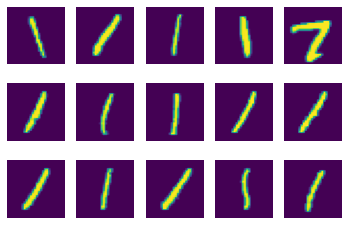

IMAGEN:


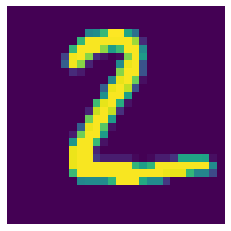

Etiqueta:  2  Prediccion:  2


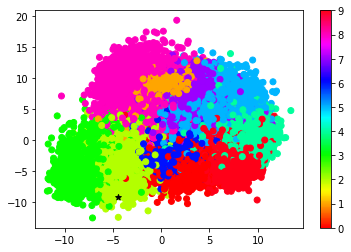

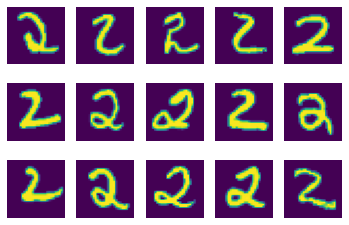

IMAGEN:


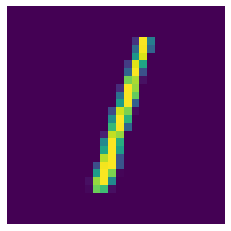

Etiqueta:  1  Prediccion:  1


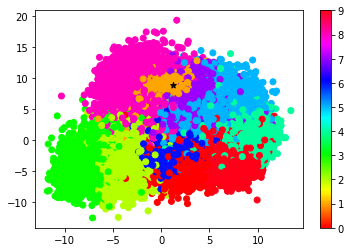

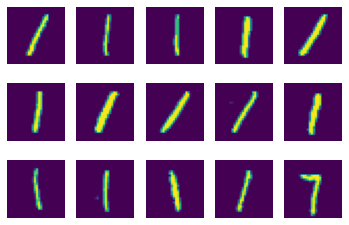

IMAGEN:


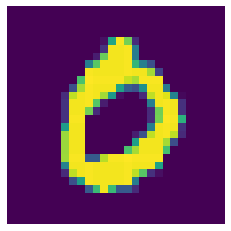

Etiqueta:  0  Prediccion:  0


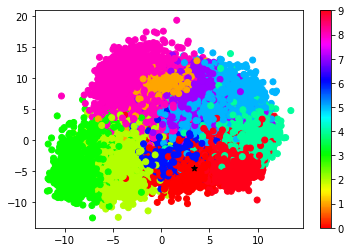

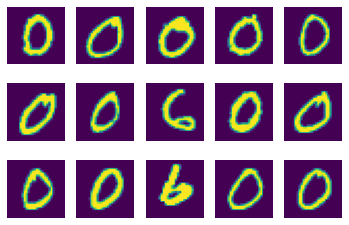

IMAGEN:


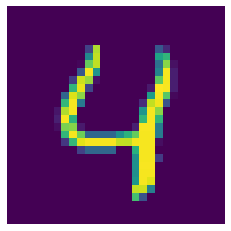

Etiqueta:  4  Prediccion:  4


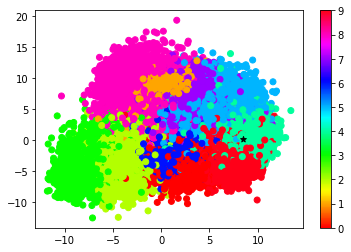

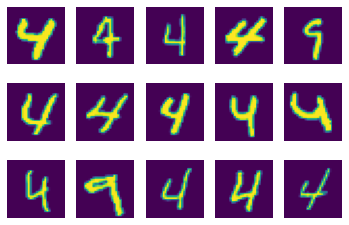

In [34]:
samples = {"data":X_test["data"][:5], "labels":X_test["labels"][:5]}
tryClassifixplain("ConvAAE2_equalweights", BBDD_dataset=X_train, samples=samples, k=15)